In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_distances
from IPython.display import clear_output, display

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_columns', 100)
pd.set_option("max_colwidth", 1000)
sns.set_style('whitegrid')

In [2]:
import recommenders


def cosine_similarity_of_non_zero_factors(v1, v2, threshold = 0):
    """
    calculates the cosine similarity of two vectors, ignoring elements that are zero
    if less than threshold elements are common and not zero on both vectors then zero is returned

    :param v1: an array representing a vector
    :param v2: an array representing a vector
    :param threshold: the minimum of elements that have to be non zero in both vectors in order to return not zero
    :return: the cosine similarity of the two vectors
    """
    sum_xx, sum_xy, sum_yy, c = 0, 0, 0, 0
    for i in range(len(v1)):
        x = v1[i]; y = v2[i]
        if x == 0 or y == 0:
            continue
        sum_xx += x*x
        sum_yy += y*y
        sum_xy += x*y
        c +=1
    if c <= threshold:
        return 0

    return sum_xy/(sum_xx*sum_yy) ** 0.5


In [3]:
def cosine_similarity_of_dataframe(dataframe: pd.DataFrame):
    """
    Calculates the cosine similarity of the rows in a dataframe
    :param dataframe: the dataframe for which the cosine_similarity is calculated
    :return: a new dataframe containingt the similarities of the rows
    """
    index_name = dataframe.index.name
    res = []
    for idx1, row1 in dataframe.iterrows():
        clear_output(wait=True)
        display(idx1)
        #print(idx1)
        res_row = {index_name : idx1}
        for idx2, row2 in dataframe.iterrows():
            similarity = cosine_similarity_of_non_zero_factors(row1.values, row2.values)
            res_row[idx2] = similarity
        res.append(res_row)
    res_df = pd.json_normalize(res)
    res_df.set_index(index_name, inplace=True)
    return res_df



In [4]:
def predict(data: pd.DataFrame, data_nan: pd.DataFrame, similarity_df: pd.DataFrame,
            row_nr: int, col_nr: int, avg_rating: float, user_weight=0.79, item_weight=-0.18 ):
    """
    predicts a single result (cell) in a dataframe

    :param data: the underling dataframe with zeros in the place of non existing values
    :param data_nan: the underling dataframe with NAN in the place of non existing values
    :param similarity_df: the dataframe with the similarities of the rows
    :param row_nr: row number of the cell that is predicted
    :param col_nr: column number of the cell that is predicted
    :param avg_rating: the average value of all ratings
    :param user_weight: the weight that is given to take the user-bias in count
    :param item_weight: the weight that is given to take the item-bias in count
    :return: the predicted value of the cell
    """
    sim_row = similarity_df.iloc[row_nr,:]
    data_col = data.iloc[:,col_nr]
    data_col_nan = data_nan.iloc[:,col_nr]
    data_row_nan = data_nan.iloc[row_nr,:]
    movie_bias = data_col_nan.mean() - avg_rating
    user_bias = data_row_nan.mean() - avg_rating
    cell_predictions = sim_row.values * data_col.values
    dividend = sum(cell_predictions)
    divisor =  sum(sim_row.values[np.nonzero(cell_predictions)])
    #print(movie_bias, user_bias)

    val_global = 0

    if movie_bias is not np.nan:
        val_global += (movie_bias * item_weight)

    if user_bias is not np.nan:
        val_global += (user_bias * user_weight)

    if dividend is np.nan or divisor is np.nan or divisor == 0:
        return val_global + avg_rating

    val = dividend / divisor
    val = val_global + val
    if val < 1:
        val = 1
    if val > 5:
        val = 5
    return val

In [5]:
def predict_df(data, data_nan, similarity_df, rows_cols, avg_rating, user_weight=0.79, item_weight=-0.18):
    """

    :param data: the underling dataframe with zeros in the place of non existing values
    :param data_nan: the underling dataframe with NAN in the place of non existing values
    :param similarity_df: the dataframe with the similarities of the rows
    :param rows_cols: two array with the row and column indices of the values that have to be predicted
    :param avg_rating:  the average value of all ratings
    :param user_weight: the weight that is given to take the user-bias in count
    :param item_weight: the weight that is given to take the item-bias in count
    :return: a new dataframe that is filled with zeros and only the predicted values are not zero
    """
    indexes = list( zip(rows_cols[0], rows_cols[1]))
    results = pd.DataFrame(np.zeros(data.shape))
    results.index = data.index
    results.columns = data.columns
    for row, column in indexes:
        val =predict(data, data_nan, similarity_df, row, column, avg_rating, user_weight, item_weight)
        results.iloc[row, column] = val
    return results


In [6]:
def recommender_builder_similitudes(data, similarity_matrix):
    """
    Given a dataset and a similarity matrix between index (users id),
    return a matrix with the recommendations for each item id.
    Args:
        data: pandas dataframe used to create the similarity matrix
        similarity_matrix: similarity matrix (np.array) after applying 1 - distance between all indexes (users_id)
    """

    recommendations = []

    for sim in similarity_matrix:
        col_recom = []

        for col, col_data in data.iteritems():
            cell_recom = sim * col_data.values
            val = sum(cell_recom) / sum(sim[np.nonzero(cell_recom)])
            if np.isnan(val):
                val = 0

            col_recom.append(val)

        recommendations.append(col_recom)

    return pd.DataFrame(recommendations, columns=data.columns, index=data.index)

In [13]:
test0 = pd.DataFrame(
    {
        'student' : ['markus', 'peter', 'lina' , 'david'] ,
        'broccoli': [10, 5, 1, 10],
        'meat': [0, 10, 1, 10 ],
        'fish': [0, 9, 1, 10 ],
        'sugar' : [1,4,0,1]
    }
)
test0.set_index('student', inplace=True)
test0.head()

,broccoli,meat,fish,sugar
student,,,,
markus,10,0,0,1
peter,5,10,9,4
lina,1,1,1,0
david,10,10,10,1


In [14]:
tdf0 = pd.DataFrame(1 - cosine_distances(test0))
tdf0.index = test0.index
tdf0.columns = test0.index
tdf0.head()

student,markus,peter,lina,david
student,,,,
markus,1.00,0.36,0.57,0.58
peter,0.36,1.00,0.93,0.94
lina,0.57,0.93,1.00,1.00
david,0.58,0.94,1.00,1.00


In [36]:
sims = cosine_similarity_of_dataframe(test0)
sims





'david'

david


,markus,peter,lina,david
student,,,,
markus,1.00,0.84,0.00,1.00
peter,0.84,1.00,0.97,0.94
lina,0.00,0.97,1.00,1.00
david,1.00,0.94,1.00,1.00


In [38]:
test0_nan = test0.replace({0: np.nan})
test0_nan

,broccoli,meat,fish,sugar
student,,,,
markus,10.00,NaN,NaN,1.00
peter,5.00,10.00,9.00,4.00
lina,1.00,1.00,1.00,NaN
david,10.00,10.00,10.00,1.00


In [39]:
test0_bal_nan = test0_nan - 4.5
test0_bal_nan

,broccoli,meat,fish,sugar
student,,,,
markus,5.50,NaN,NaN,-3.50
peter,0.50,5.50,4.50,-0.50
lina,-3.50,-3.50,-3.50,NaN
david,5.50,5.50,5.50,-3.50


In [40]:
test0_bal = test0_bal_nan.replace({np.nan: 0})
test0_bal

,broccoli,meat,fish,sugar
student,,,,
markus,5.50,0.00,0.00,-3.50
peter,0.50,5.50,4.50,-0.50
lina,-3.50,-3.50,-3.50,0.00
david,5.50,5.50,5.50,-3.50


In [41]:
sims_bal = cosine_similarity_of_dataframe(test0_bal)
sims_bal


'david'

david


,markus,peter,lina,david
student,,,,
markus,1.00,0.98,-1.00,1.00
peter,0.98,1.00,-0.85,0.82
lina,-1.00,-0.85,1.00,-1.00
david,1.00,0.82,-1.00,1.00


In [20]:
df = pd.read_csv('food2.csv')
df.drop(['age', 'favorite_color'], axis=1, inplace=True)
df.set_index('student', inplace=True)

food = df.copy()
food
train, test = recommenders.recommender_train_test(data=food, test_size=0.1)

sims = cosine_similarity_of_dataframe(train)
sims

'Joan'

Joan


,Markus,Peter,Shikha,Hashim,Lina,David,Khader,Archana,Vitaly,Joan
student,,,,,,,,,,
Markus,0,0,0,0,0,0,0,0,0,0
Peter,0,0,0,0,0,0,0,0,0,0
Shikha,0,0,0,0,0,0,0,0,0,0
Hashim,0,0,0,0,0,0,0,0,0,0
Lina,0,0,0,0,0,0,0,0,0,0
David,0,0,0,0,0,0,0,0,0,0
Khader,0,0,0,0,0,0,0,0,0,0
Archana,0,0,0,0,0,0,0,0,0,0
Vitaly,0,0,0,0,0,0,0,0,0,0


In [21]:
# predict(train, sims, 0,0)

In [22]:
not_null = np.nonzero(np.array(test))
not_null

(array([0, 0, 1, 4, 5, 5, 6, 8], dtype=int64),
 array([0, 5, 2, 4, 6, 8, 6, 5], dtype=int64))

In [23]:
# predict_df(train, sims, not_null)

### Read the Data

In [9]:
movies = pd.read_csv('../Day 4/u.data/u.data.csv', sep='\t', header=None)
movies.columns = ['user_id','item_id','ratings','timestamp']
print('shape: ',movies.shape)
print('ratings value counts')
print(movies.ratings.value_counts())
print()
print('description of ratings')
print(movies.ratings.describe())
avg_rating = movies.ratings.describe()[1]
print('number of ratings of type NAN: ', movies.ratings.isna().sum())
print()
movies.head(10)

shape:  (100000, 4)
ratings value counts
4    34174
3    27145
5    21201
2    11370
1     6110
Name: ratings, dtype: int64

description of ratings
count   100000.00
mean         3.53
std          1.13
min          1.00
25%          3.00
50%          4.00
75%          4.00
max          5.00
Name: ratings, dtype: float64
number of ratings of type NAN:  0



,user_id,item_id,ratings,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806
6,115,265,2,881171488
7,253,465,5,891628467
8,305,451,3,886324817
9,6,86,3,883603013


### Handling Cold Start Problem

In [10]:
def delete_movies_that_have_fewer_n_ratings(dataframe, n=5):
    dataframe['idx'] = dataframe.index
    while True:
        grouped_movies =dataframe.groupby('item_id')\
        .agg(
            idx=pd.NamedAgg(column='idx', aggfunc="first"),
            count=pd.NamedAgg(column="user_id", aggfunc="count"))
        movies_with_too_few_ratings = grouped_movies[grouped_movies['count'] < n]
        if len(movies_with_too_few_ratings) == 0:
            break
        idx_to_delete = movies_with_too_few_ratings['idx'].values
        dataframe = dataframe.drop(idx_to_delete)
    dataframe.drop(['idx'], axis=1, inplace=True)
    return dataframe



In [11]:
print(len(movies))
movies = delete_movies_that_have_fewer_n_ratings(movies)
print(len(movies))

100000
99287


In [12]:
movies_group_by_users = movies.groupby('user_id')\
        .agg(average=pd.NamedAgg(column="ratings", aggfunc="mean"),
             count=pd.NamedAgg(column="ratings", aggfunc="count"))
movies_group_by_users.sort_values(by='count').head(20)

,average,count
user_id,,
242,4.42,19
36,3.74,19
873,2.90,20
441,3.50,20
824,2.60,20
812,3.50,20
809,3.45,20
93,3.35,20
866,2.70,20


In [13]:
movies_group_by_items = movies.groupby('item_id')\
        .agg(average=pd.NamedAgg(column="ratings", aggfunc="mean"),
             count=pd.NamedAgg(column="ratings", aggfunc="count"))
print(movies_group_by_items.sort_values(by='count').head(20))
print(movies_group_by_items.sort_values(by='count').tail(20))

         average  count
item_id                
1397        3.20      5
1138        3.40      5
1324        2.40      5
439         1.00      5
1333        2.80      5
920         2.20      5
314         1.00      5
666         2.40      5
1108        2.40      5
1344        3.20      5
1346        2.40      5
1470        2.60      5
1353        2.60      5
1367        4.20      5
1378        2.20      5
104         1.40      5
1385        2.80      5
1442        2.40      5
1392        2.00      5
1440        3.00      5
         average  count
item_id                
204         3.83    350
222         3.66    365
172         4.20    367
117         3.69    378
237         3.71    384
98          4.29    390
7           3.80    392
56          4.06    394
127         4.28    413
174         4.25    420
121         3.44    429
300         3.63    431
1           3.88    452
288         3.44    478
286         3.66    481
294         3.16    485
181         4.01    507
100         4.16

### Create Pivot Table

In [14]:
pivot_movies = movies.pivot(index='user_id', values='ratings', columns='item_id')
print('shape: ', pivot_movies.shape)
print('sparsity of the data: ', pivot_movies.isna().sum().sum() / (pivot_movies.shape[0] * pivot_movies.shape[1]))
pivot_movies.replace({np.nan: 0}, inplace=True)
print(pivot_movies.info())
pivot_movies.head(10)


# sns.set_style('whitegrid')
# plt.subplots(figsize=(25,25))
# sns.heatmap(data=pm.isna())



shape:  (943, 1349)
sparsity of the data:  0.9219507478537576
<class 'pandas.core.frame.DataFrame'>
Int64Index: 943 entries, 1 to 943
Columns: 1349 entries, 1 to 1620
dtypes: float64(1349)
memory usage: 9.7 MB
None


item_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,...,1441,1442,1444,1446,1449,1451,1454,1456,1459,1462,1466,1468,1469,1470,1471,1473,1474,1475,1478,1479,1480,1483,1487,1489,1495,1496,1501,1503,1509,1511,1512,1514,1517,1518,1522,1524,1527,1529,1530,1531,1534,1540,1555,1558,1591,1592,1597,1598,1615,1620
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.00,3.00,4.00,3.00,3.00,5.00,4.00,1.00,5.00,3.00,2.00,5.00,5.00,5.00,5.00,5.00,3.00,4.00,5.00,4.00,1.00,4.00,4.00,3.00,4.00,3.00,2.00,4.00,1.00,3.00,3.00,5.00,4.00,2.00,1.00,2.00,2.00,3.00,4.00,3.00,2.00,5.00,4.00,5.00,5.00,4.00,4.00,5.00,3.00,5.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,4.00,4.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,4.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,0.00,0.00,3.00,0.00,0.00,4.00,3.00,0.00,0.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,4.00,0.00,0.00,0.00,0.00,0.00,2.00,4.00,4.00,0.00,0.00,4.00,2.00,5.00,3.00,0.00,0.00,0.00,4.00,0.00,3.00,3.00,4.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,4.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,5.00,0.00,0.00,5.00,5.00,5.00,4.00,3.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,3.00,0.00,3.00,0.00,4.00,5.00,3.00,0.00,4.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,5.00,0.00,0.00,5.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0

### Train/Test Split

In [15]:
train_movies, test_movies = recommenders.recommender_train_test(data=pivot_movies, test_size=0.05)
train_movies_nan = train_movies.replace({0: np.nan})
test_movies_nan =  test_movies.replace({0: np.nan})
print('number of train samples: ', (train_movies_nan.shape[0] * train_movies_nan.shape[1]) - train_movies_nan.isna().sum().sum())
print('number of test samples:  ', (test_movies_nan.shape[0] * test_movies_nan.shape[1]) - test_movies_nan.isna().sum().sum())

number of train samples:  94322
number of test samples:   4965


### Calculate Similarities
Takes about 5 minutes

In [16]:
user_similarities_balanced = cosine_similarity_of_dataframe(train_movies)
print(user_similarities_balanced.shape)

943

(943, 943)


In [17]:
user_similarities_balanced.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,...,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.00,0.96,0.85,0.92,0.93,0.95,0.94,0.98,1.00,0.97,0.95,0.96,0.93,0.95,0.87,0.96,0.95,0.95,0.87,0.90,0.93,0.97,0.95,0.95,0.96,0.95,0.97,0.95,0.96,0.95,0.96,0.97,0.86,0.95,0.67,0.67,0.96,0.85,1.00,0.95,0.97,0.95,0.94,0.95,0.97,0.97,0.96,0.93,0.87,0.92,...,0.96,0.99,0.93,0.95,0.97,0.96,0.92,0.92,0.91,0.96,0.89,0.97,0.96,0.95,0.98,0.94,0.95,0.96,0.93,0.94,0.76,0.98,0.97,0.92,0.90,0.92,0.99,0.92,0.94,0.96,0.98,0.92,0.98,0.91,0.95,0.97,0.90,0.92,0.96,0.93,0.94,0.86,0.97,0.92,0.92,0.94,0.95,0.98,0.92,0.93
2,0.96,1.00,0.95,0.95,0.98,0.96,0.96,0.95,0.94,0.98,0.98,0.99,0.92,0.96,0.93,0.93,0.90,0.98,0.88,0.97,0.94,0.97,0.96,0.98,0.96,0.97,0.96,0.92,0.95,0.93,0.99,0.95,0.98,0.97,0.97,0.97,0.98,0.80,0.88,0.90,0.97,0.90,0.94,0.94,0.99,0.97,0.97,0.85,0.92,0.89,...,0.97,0.96,0.94,0.95,0.88,0.97,0.84,0.92,0.96,0.98,0.98,0.97,0.96,0.97,0.98,1.00,0.98,0.95,0.00,0.93,0.94,0.93,0.98,0.97,0.99,0.98,0.96,0.91,0.94,0.97,0.98,0.93,0.95,0.91,0.99,0.97,0.96,0.96,0.96,0.98,0.94,0.96,0.97,0.97,0.95,0.98,0.94,0.94,0.97,0.97
3,0.85,0.95,1.00,0.92,1.00,0.89,0.89,0.89,1.00,0.93,0.84,0.95,0.84,0.92,0.89,0.87,0.80,0.91,0.87,0.92,0.84,0.95,0.91,0.96,0.95,0.88,1.00,0.91,0.94,0.90,0.91,0.94,0.94,0.89,0.85,0.98,1.00,0.86,0.89,0.85,1.00,1.00,0.86,0.93,0.98,0.90,0.95,1.00,0.87,0.90,...,0.93,0.98,0.82,0.87,0.87,0.90,1.00,0.81,0.92,0.96,0.89,0.90,0.97,0.84,0.94,0.96,0.77,1.00,0.98,0.83,0.00,0.90,0.96,0.84,1.00,0.90,0.90,0.97,0.97,0.94,0.96,0.85,0.88,0.86,0.90,0.98,0.85,0.89,0.00,0.89,0.96,0.95,0.92,0.85,0.87,0.99,0.85,0.97,0.94,0.99
4,0.92,0.95,0.92,1.00,0.99,0.94,0.90,0.97,0.99,0.97,0.88,0.98,0.89,0.94,0.98,0.98,1.00,0.96,0.99,0.88,0.97,0.86,0.91,0.97,1.00,0.99,1.00,0.98,0.99,0.98,0.97,0.98,0.98,0.89,0.94,0.91,0.99,0.98,0.96,0.98,1.00,0.97,0.98,0.99,0.99,0.94,0.99,0.96,0.90,0.97,...,0.97,0.98,0.91,0.93,0.93,0.99,0.98,0.96,0.95,0.97,0.99,0.99,1.00,0.97,0.98,1.00,0.98,1.00,1.00,0.89,0.00,0.98,0.99,1.00,0.00,0.97,0.97,0.95,0.97,0.99,0.95,0.96,0.99,0.99,0.88,0.98,0.92,0.98,1.00,0.99,0.97,1.00,0.95,0.90,0.96,1.00,0.97,1.00,0.98,0.98
5,0.93,0.98,1.00,0.99,1.00,0.93,0.91,0.93,0.88,0.94,0.92,0.86,0.90,0.96,0.89,0.93,0.98,0.92,0.96,0.94,0.91,0.93,0.93,0.88,0.97,0.97,0.99,0.96,0.90,0.92,0.99,0.96,0.00,1.00,0.95,0.00,0.97,0.80,0.00,1.00,0.95,0.91,0.93,0.96,0.98,0.98,0.00,0.95,0.85,1.00,...,0.91,0.97,0.91,0.90,1.00,0.93,0.94,0.91,0.93,0.94,0.70,1.00,0.99,0.93,0.94,1.00,0.93,0.95,0.93,0.90,0.78,0.00,0.93,0.93,0.84,0.94,0.00,0.91,0.92,0.97,0.93,0.99,0.00,0.91,0.97,0.93,0.92,0.99,0.95,0.89,0.92,0.94,0.94,0.96,0.93,0.94,0.92,0.99,0.95,0.90


In [18]:
def error_check22(data, recommendations):
    import numpy as np
    from sklearn.metrics import mean_squared_error
    # find out the values different from 0 in the dataset we want to check the recommendations, and look at the same position in the recommendations dataset
    val = np.array(data)[np.nonzero(np.array(data))]
    pred = np.array(recommendations)[np.nonzero(np.array(data))]

    # mean squared error calculations
    return mean_squared_error(val, pred)

In [19]:
indexes_of_values_to_predict = np.nonzero(np.array(test_movies))
indexes_of_values_to_predict

(array([  0,   0,   0, ..., 942, 942, 942], dtype=int64),
 array([ 53,  70,  97, ..., 505, 710, 991], dtype=int64))

### Run the prediction and plot the error

In [20]:
user_w = [0.73,0.74, 0.75, 0.76, 0.78, 0.79, 0.8, 0.82 ]
item_w = [-0.26, -0.25,   -0.24, -0.23, -0.22,   -0.21,  -0.2,  -0.19, -0.18]
for item_weight in item_w:
    for user_weight in user_w:
        # print('user-weight: ', user_weight, 'item-weight: ' ,item_weight)
        predictions = predict_df(train_movies, train_movies_nan, user_similarities_balanced, indexes_of_values_to_predict, avg_rating, user_weight, item_weight)
        #predictions.replace({np.nan: int(avg_rating)}, inplace=True)
        error22 = error_check22(test_movies, predictions)
        print(error22, 'user-weight: ', user_weight, 'item-weight: ' ,item_weight)




0.9320461708693254 user-weight:  0.73 item-weight:  -0.26
0.9318246868892154 user-weight:  0.74 item-weight:  -0.26
0.9316419904278874 user-weight:  0.75 item-weight:  -0.26
0.9314980814853414 user-weight:  0.76 item-weight:  -0.26
0.9313266261565961 user-weight:  0.78 item-weight:  -0.26
0.9312990797703966 user-weight:  0.79 item-weight:  -0.26
0.9313103209029794 user-weight:  0.8 item-weight:  -0.26
0.9314220941491271 user-weight:  0.82 item-weight:  -0.26
0.9314660693508997 user-weight:  0.73 item-weight:  -0.25
0.931250176651422 user-weight:  0.74 item-weight:  -0.25
0.9310730714707265 user-weight:  0.75 item-weight:  -0.25
0.9309347538088129 user-weight:  0.76 item-weight:  -0.25
0.9307744810413322 user-weight:  0.78 item-weight:  -0.25
0.930752525935765 user-weight:  0.79 item-weight:  -0.25
0.9307637508541888 user-weight:  0.8 item-weight:  -0.25
0.9308814741765679 user-weight:  0.82 item-weight:  -0.25
0.9309368287610773 user-weight:  0.73 item-weight:  -0.24
0.9307265273422317

MSE:  0.9501858325869821


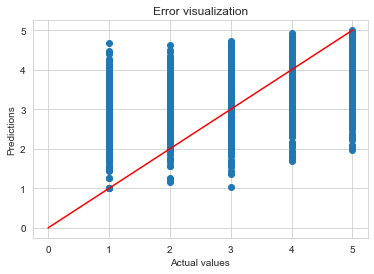

In [21]:
predictions = predict_df(train_movies, train_movies_nan, user_similarities_balanced, indexes_of_values_to_predict, avg_rating, 0.55, 0.1)
#predictions.replace({np.nan: int(avg_rating)}, inplace=True)
recommenders.recommender_error_check(test_movies, predictions)


In [23]:
#predict()

